In [1]:
import matplotlib.pylab as plt
%matplotlib inline
import cv2

import pandas as pd
import numpy as np

In [2]:
# metric
def get_iou(boxA, boxB):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.
    Parameters
    ----------
    boxA = np.array( [ xmin,ymin,xmax,ymax ] )
    boxB = np.array( [ xmin,ymin,xmax,ymax ] )
    Returns
    -------
    float
    in [0, 1]
    """

    bb1 = dict()
    bb1['x1'] = boxA[0]
    bb1['y1'] = boxA[1]
    bb1['x2'] = boxA[2]
    bb1['y2'] = boxA[3]

    bb2 = dict()
    bb2['x1'] = boxB[0]
    bb2['y1'] = boxB[1]
    bb2['x2'] = boxB[2]
    bb2['y2'] = boxB[3]

    # Determine the coordinates of the intersection rectangle
    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
        #print('check')
        return 0.0

    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # Compute the area of both bounding boxes area
    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])

    # Compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the intersection area
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)

    assert iou >= 0.0
    assert iou <= 1.0

    return iou

### Example of metric on one face

In [3]:
face_cascade = cv2.CascadeClassifier('../v0_prototype/data/haarcascade_frontalface_default.xml')

In [4]:
img = cv2.imread('../../../WIDER_train/images/0--Parade/0_Parade_Parade_0_1040.jpg')

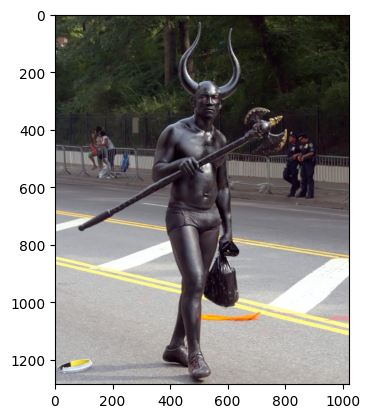

In [5]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB));

In [6]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
faces = face_cascade.detectMultiScale(gray, 1.1, 4)

In [7]:
faces

array([[501, 260,  75,  75]], dtype=int32)

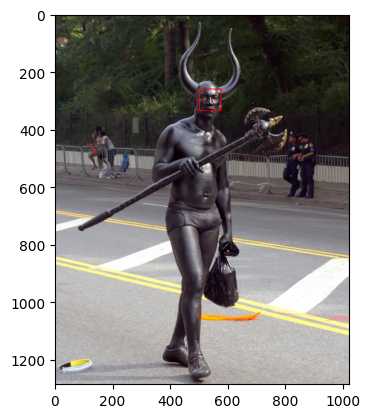

In [8]:
for (x, y, w, h) in faces:
    cv2.rectangle(img, (x, y), (x+w, y+h), (0, 0, 255), 2)
    
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB));

In [9]:
train_labels = pd.read_csv('../../../wider_face_split/wider_face_train_bbx_gt.txt', header=None)

In [10]:
ind_lab = train_labels[train_labels[0] == '0--Parade/0_Parade_Parade_0_1040.jpg'].index[0]

In [11]:
train_labels.iloc[ind_lab:ind_lab+3]

,0
10418,0--Parade/0_Parade_Parade_0_1040.jpg
10419,1
10420,494 251 75 110 0 0 0 0 2 0


In [12]:
coords = train_labels.iloc[(ind_lab+2)].apply(lambda x: x.split())[0][:4]

In [13]:
np.array([[int(i) for i in coords]])

array([[494, 251,  75, 110]])

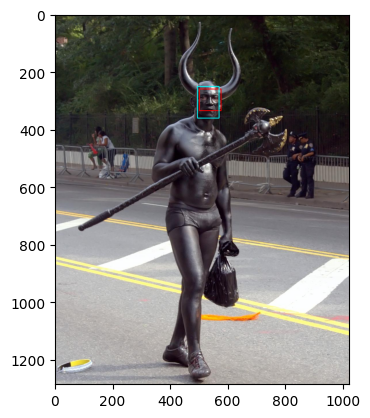

In [14]:
for (x, y, w, h) in np.array([[int(i) for i in coords]]):
    cv2.rectangle(img, (x, y), (x+w, y+h), (255, 255, 0), 2)
    
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB));

In [15]:
y_true = [int(i) for i in coords]
y_true[2] = y_true[0] + y_true[2]
y_true[3] = y_true[1] + y_true[3]

y_pred = [int(i) for i in faces[0]]
y_pred[2] = y_pred[0] + y_pred[2]
y_pred[3] = y_pred[1] + y_pred[3]

In [16]:
iou = get_iou(np.array(y_true), np.array(y_pred))
iou

0.5811965811965812

### Example of metric on many faces

In [17]:
img2 = cv2.imread('../../../WIDER_train/images/20--Family_Group/20_Family_Group_Family_Group_20_1009.jpg')

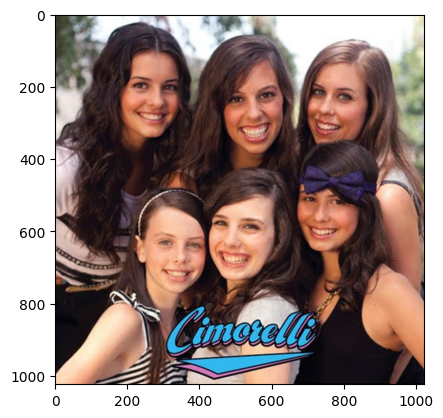

In [18]:
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB));

In [19]:
gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
faces = face_cascade.detectMultiScale(gray, 1.1, 4)

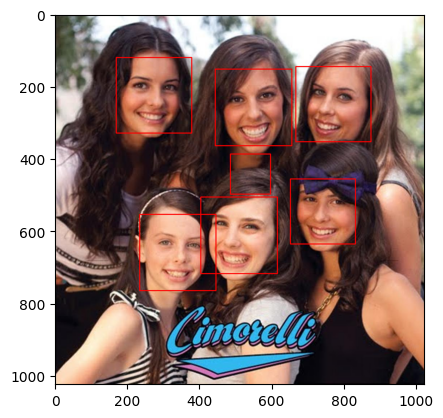

In [20]:
for (x, y, w, h) in faces:
    cv2.rectangle(img2, (x, y), (x+w, y+h), (0, 0, 255), 2)
    
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB));

In [21]:
y_pred = [[int(i) for i in list(j)] for j in faces]

In [22]:
ind_lab = train_labels[train_labels[0] == '20--Family_Group/20_Family_Group_Family_Group_20_1009.jpg'].index[0]
num_faces = int(train_labels.iloc[ind_lab+1][0])
y_true = np.array(list(train_labels.iloc[ind_lab+2:ind_lab+num_faces+2][0] \
    .apply(lambda x: x.split()[:4]).apply(lambda x: [int(i) for i in x])))

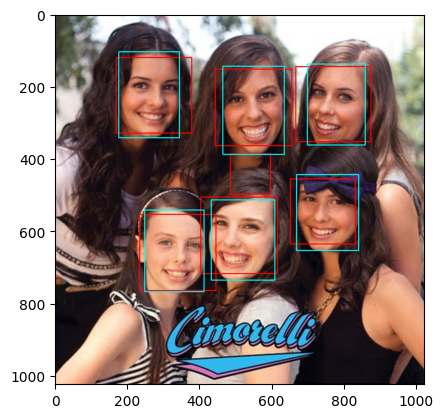

In [23]:
for (x, y, w, h) in y_true:
    cv2.rectangle(img2, (x, y), (x+w, y+h), (255, 255, 0), 2)
    
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB));

In [24]:
for i in range(len(y_pred)):
    y_pred[i][2] = y_pred[i][2] + y_pred[i][0]
    y_pred[i][3] = y_pred[i][3] + y_pred[i][1]
for i in range(len(y_true)):
    y_true[i][2] = y_true[i][2] + y_true[i][0]
    y_true[i][3] = y_true[i][3] + y_true[i][1]

In [25]:
total_iou = 0
pred_dict = dict()
for gt in y_true:
    max_iou_per_gt = 0
    for i, pred in enumerate(y_pred):
        if i not in pred_dict.keys():
            pred_dict[i] = 0
        iou = get_iou(gt, pred)
        if iou > max_iou_per_gt:
            max_iou_per_gt = iou
        if iou > pred_dict[i]:
            pred_dict[i] = iou
    total_iou = total_iou + max_iou_per_gt
iou = total_iou / len(y_true)
iou

0.7327325308525893